<a href="https://colab.research.google.com/github/ApahSaroj/WPI/blob/main/Darts_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/DATA/timeser.csv')
df

,Date,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WPI
0,01-Jan-14,8.14,8.7,84.0,52,147.8,4.48,44,20,1.17,0.285,7.80,0.758000,6.534660,0.06211,0.249528
1,02-Jan-14,7.70,8.8,110.0,76,188.0,8.61,44,36,3.46,0.401,14.80,0.196062,8.138620,0.00960,0.216400
2,03-Jan-14,7.60,7.5,75.0,44,128.0,8.11,28,20,2.80,0.379,14.80,0.298875,3.855625,0.01280,0.183814
3,04-Jan-14,8.20,9.1,76.0,56,127.0,6.30,44,18,1.65,0.396,9.60,0.299590,2.238750,0.01536,0.219282
4,05-Jan-14,7.31,7.3,84.0,52,140.0,5.50,28,20,1.61,0.265,8.30,0.106000,5.600000,0.01000,0.165831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,28-Apr-15,7.60,5.6,224.0,8,370.0,16.14,92,24,7.60,2.270,23.04,1.352000,104.480000,0.01500,0.419630
483,29-Apr-15,7.30,5.6,266.0,96,434.0,20.56,96,32,9.89,1.550,30.86,7.074000,61.068000,0.03300,0.432996
484,30-Apr-15,5.10,5.8,290.0,12,487.0,37.35,60,44,14.80,0.159,60.13,9.256000,89.910000,0.16300,0.326811
485,01-May-15,7.40,6.4,230.0,72,385.0,20.06,70,42,10.35,1.360,32.92,7.110436,48.500000,0.21900,0.509970


In [4]:
df=df.drop(['pH','DO','TDS','Alkalinity',	'EC',	'Na',	'Ca',	'Mg',	'K',	'F',	'Cl',	'Nitrate',	'Sulphate',	'Phosphate'], axis = 1)

In [5]:
## Cleaning up the data
df.columns=["Month","WPI"]
df.head()

,Month,WPI
0,01-Jan-14,0.249528
1,02-Jan-14,0.216400
2,03-Jan-14,0.183814
3,04-Jan-14,0.219282
4,05-Jan-14,0.165831


In [6]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])

In [7]:
df.head()

,Month,WPI
0,2014-01-01,0.249528
1,2014-01-02,0.216400
2,2014-01-03,0.183814
3,2014-01-04,0.219282
4,2014-01-05,0.165831


In [8]:
#df.set_index('Month',inplace=True)

In [9]:
#df.head()

In [10]:
pip install darts

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [12]:
series = TimeSeries.from_dataframe(df, 'Month','WPI')

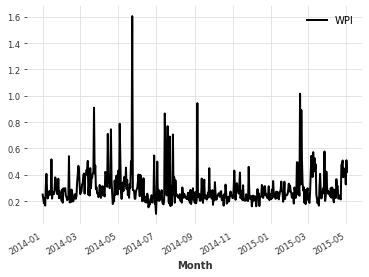

In [13]:
series.plot()

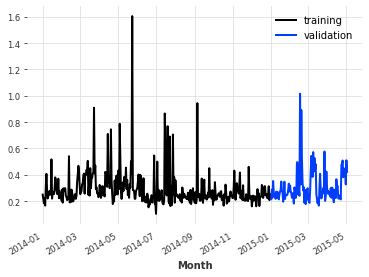

In [14]:
train, val = series.split_before(pd.Timestamp('20150101'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

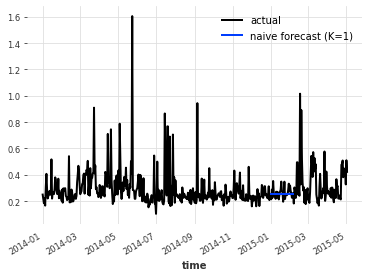

In [15]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend();

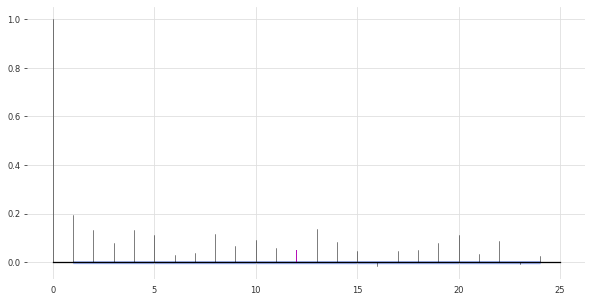

In [16]:
plot_acf(train, m = 12, alpha = .05)

In [17]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 4.
There is seasonality of order 8.
There is seasonality of order 10.
There is seasonality of order 13.
There is seasonality of order 20.
There is seasonality of order 22.


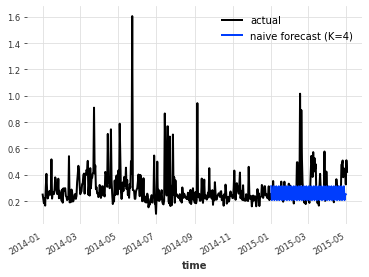

In [18]:
seasonal_model = NaiveSeasonal(K=4)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(120)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=4)')
plt.legend();

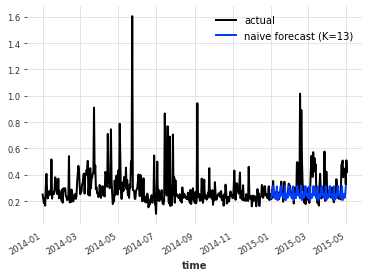

In [19]:
seasonal_model = NaiveSeasonal(K=13)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(120)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=13)')
plt.legend();

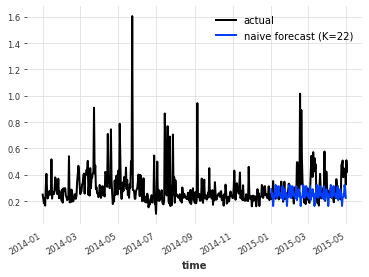

In [20]:
seasonal_model = NaiveSeasonal(K=22)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(120)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=22)')
plt.legend();

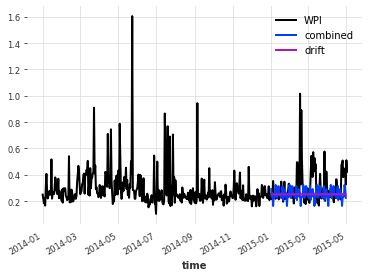

In [21]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(120)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend();

In [22]:
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
      mape(series, combined_forecast)))

Mean absolute percentage error for the combined naive drift + seasonal: 25.41%.


In [23]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

model Exponential smoothing obtains MAPE: 22.04%
model Prophet obtains MAPE: 28.25%
model Auto-ARIMA obtains MAPE: 21.13%
model Theta(2) obtains MAPE: 21.59%


In [24]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta

In [25]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

The MAPE is: 20.99, with theta = 0.5714285714285712.


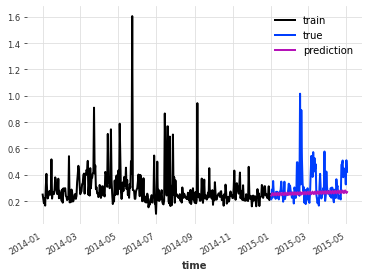

In [26]:
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend();

100%|██████████| 304/304 [00:12<00:00, 24.31it/s]


Average error (MAPE) over all historical forecasts: 24.339547374614174
Median error (MAPE) over all historical forecasts: 20.03969334578329


100%|██████████| 304/304 [00:12<00:00, 25.04it/s]


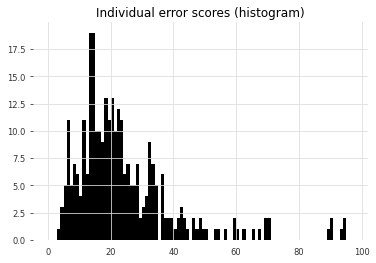

100%|██████████| 304/304 [00:12<00:00, 24.87it/s]


In [27]:
best_theta_model = Theta(best_theta)

average_error = best_theta_model.backtest(series, start=pd.Timestamp('20140701'), forecast_horizon=3, verbose=True)
median_error = best_theta_model.backtest(series, start=pd.Timestamp('20140701'), forecast_horizon=3, reduction=np.median, verbose=True)
print("Average error (MAPE) over all historical forecasts: {}".format(average_error))
print("Median error (MAPE) over all historical forecasts: {}".format(median_error))

raw_errors = best_theta_model.backtest(series, start=pd.Timestamp('20140701'), forecast_horizon=3, reduction=None, verbose=True)
plt.hist(raw_errors, bins=np.arange(0, max(raw_errors), 1))
plt.title("Individual error scores (histogram)")
plt.show()

historical_fcast_theta = best_theta_model.historical_forecasts(series, start=pd.Timestamp('20140701'), forecast_horizon=3, verbose=True)

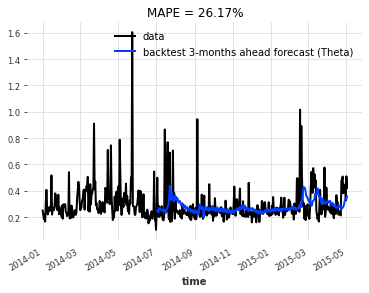

In [28]:
series.plot(label='data')
historical_fcast_theta.plot(label='backtest 3-months ahead forecast (Theta)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_theta, series)))
plt.legend();

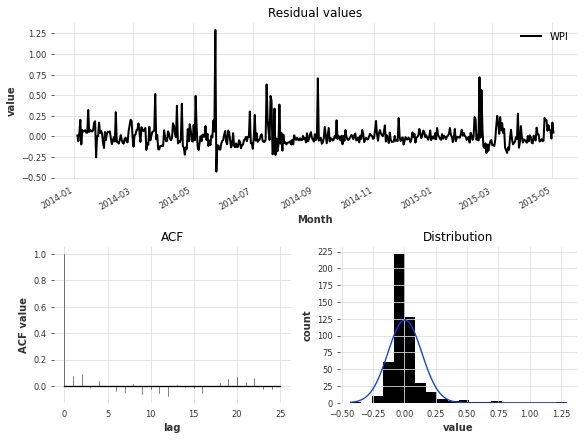

In [29]:
plot_residuals_analysis(best_theta_model.residuals(series))

100%|██████████| 304/304 [00:56<00:00,  5.41it/s]


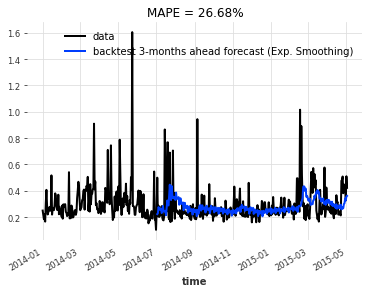

In [30]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(series, start=pd.Timestamp('20140701'), forecast_horizon=3, verbose=True)

series.plot(label='data')
historical_fcast_es.plot(label='backtest 3-months ahead forecast (Exp. Smoothing)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_es, series)))
plt.legend()
plt.show()

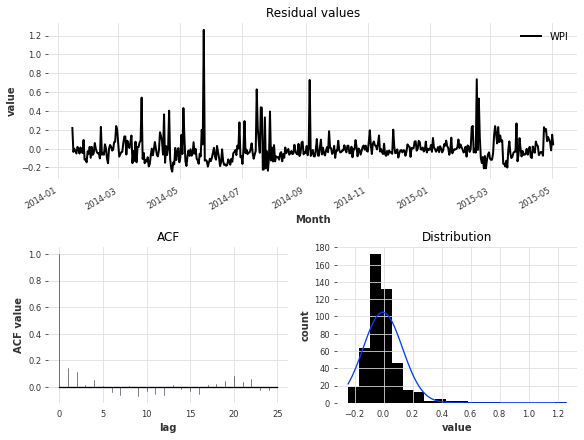

In [31]:
plot_residuals_analysis(model_es.residuals(series))

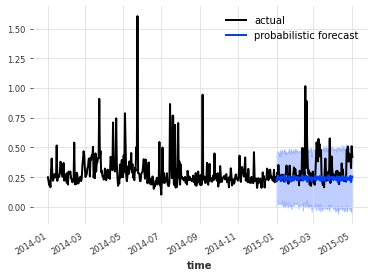

In [32]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label='actual')
probabilistic_forecast.plot(label='probabilistic forecast')
plt.legend()
plt.show()

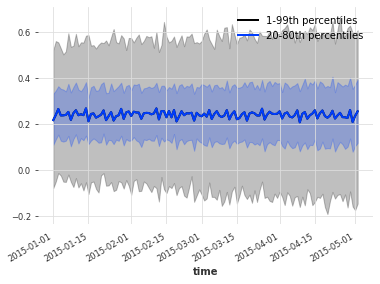

In [33]:
probabilistic_forecast.plot(low_quantile=0.01, high_quantile=0.99, label='1-99th percentiles')
probabilistic_forecast.plot(low_quantile=0.2, high_quantile=0.8, label='20-80th percentiles')

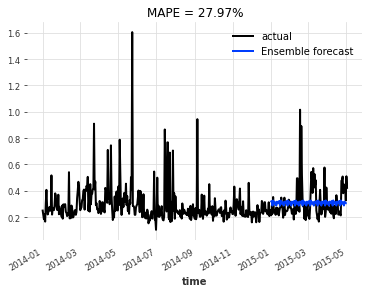

In [34]:
ensemble_model = RegressionEnsembleModel(
    forecasting_models=[NaiveSeasonal(6), NaiveSeasonal(12), NaiveDrift()],
    regression_train_n_points=12)

ensemble_model.fit(train)
ensemble_pred = ensemble_model.predict(120)

series.plot(label='actual')
ensemble_pred.plot(label='Ensemble forecast')
plt.title('MAPE = {:.2f}%'.format(mape(ensemble_pred, series)))
plt.legend();

100%|██████████| 304/304 [00:29<00:00, 10.42it/s]


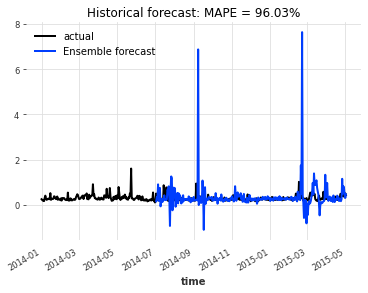

In [35]:
ensemble_pred_hist = ensemble_model.historical_forecasts(series,
                                                    start=pd.Timestamp('20140701'),
                                                    forecast_horizon=3,
                                                    verbose=True)
series.plot(label='actual')
ensemble_pred_hist.plot(label='Ensemble forecast')
plt.title('Historical forecast: MAPE = {:.2f}%'.format(mape(ensemble_pred_hist, series)))
plt.legend();

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [37]:
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('20140701'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('20140701'))

In [38]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='WPI_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True
)

In [39]:
my_model.fit(train_transformed, 
             future_covariates=covariates, 
             val_series=val_transformed, 
             val_future_covariates=covariates, 
             verbose=True)

  0%|          | 1/300 [00:00<02:14,  2.23it/s]

  4%|▍         | 12/300 [00:03<01:15,  3.79it/s]

  7%|▋         | 21/300 [00:05<01:17,  3.58it/s]

 10%|█         | 31/300 [00:07<01:17,  3.45it/s]

 14%|█▎        | 41/300 [00:09<01:13,  3.52it/s]

 17%|█▋        | 51/300 [00:12<01:08,  3.63it/s]

 20%|██        | 61/300 [00:14<01:05,  3.62it/s]

 24%|██▍       | 72/300 [00:16<00:57,  3.96it/s]

 27%|██▋       | 81/300 [00:19<01:02,  3.48it/s]

 30%|███       | 91/300 [00:21<00:59,  3.52it/s]

 34%|███▍      | 102/300 [00:24<00:49,  4.01it/s]

 37%|███▋      | 112/300 [00:26<00:47,  3.99it/s]

 40%|████      | 121/300 [00:28<00:56,  3.19it/s]

 44%|████▎     | 131/300 [00:30<00:45,  3.68it/s]

 47%|████▋     | 141/300 [00:33<00:43,  3.68it/s]

 50%|█████     | 151/300 [00:35<00:40,  3.67it/s]

 54%|█████▎    | 161/300 [00:37<00:38,  3.63it/s]

 57%|█████▋    | 171/300 [00:40<00:35,  3.58it/s]

 61%|██████    | 182/300 [00:42<00:29,  4.06it/s]

 64%|██████▎   | 191/300 [00:44<00:29,  3.64it/s]

 67%|██████▋   | 202/300 [00:47<00:24,  3.96it/s]

 70%|███████   | 211/300 [00:49<00:26,  3.32it/s]

 74%|███████▎  | 221/300 [00:51<00:21,  3.64it/s]

 77%|███████▋  | 231/300 [00:54<00:18,  3.65it/s]

 81%|████████  | 242/300 [00:56<00:14,  3.91it/s]

 84%|████████▎ | 251/300 [00:58<00:15,  3.26it/s]

 87%|████████▋ | 261/300 [01:01<00:10,  3.57it/s]

 90%|█████████ | 271/300 [01:03<00:08,  3.52it/s]

 94%|█████████▎| 281/300 [01:05<00:05,  3.62it/s]

 97%|█████████▋| 291/300 [01:08<00:03,  2.85it/s]

100%|██████████| 300/300 [01:10<00:00,  4.28it/s]


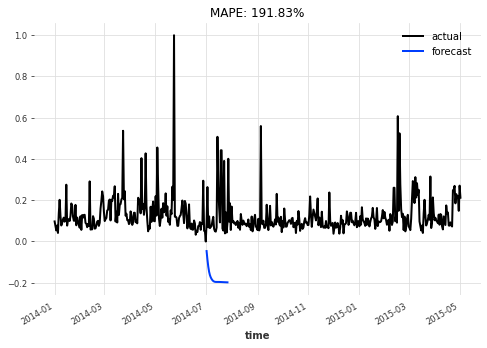

In [40]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

loading model_best_10.pth.tar


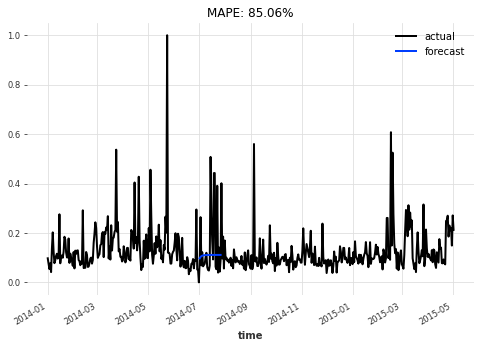

In [41]:
best_model = RNNModel.load_from_checkpoint(model_name='WPI_RNN', best=True)
eval_model(best_model)

In [42]:
backtest_series = my_model.historical_forecasts(series_transformed,
                                                future_covariates=covariates,
                                                start=pd.Timestamp('20140701'),
                                                forecast_horizon=6,
                                                retrain=False,
                                                verbose=True)

100%|██████████| 301/301 [00:06<00:00, 44.55it/s]


MAPE: 64.18%


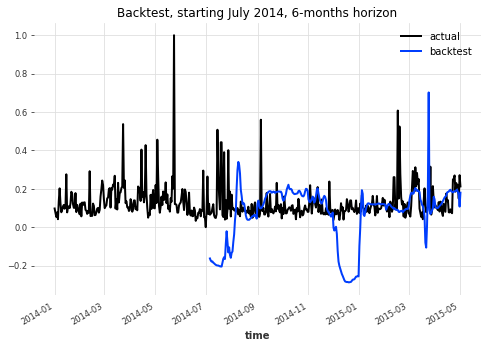

In [43]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest, starting July 2014, 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))